# Model2
This notebook is a deeper iteration of similar architecture from model 1 set up for the purpose of running on AWS.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.style.use('fivethirtyeight')
%matplotlib inline

from tensorflow.keras.applications import NASNetLarge 
from tensorflow.keras.applications.nasnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, model_from_json, load_model
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

from nltk.translate.bleu_score import corpus_bleu

import pickle
import os
from timeit import default_timer as timer

import string
import re
import gc

In [2]:
# remove unnecessary variables
def clean_up(vars_):
    for var in vars_:
        del var 
    print(gc.collect())

In [3]:
flicker_img_dir = 'IMAGES/Flicker/Flicker8k_Dataset'
art_dir = 'IMAGES\paintings'

## Functions
---
Setting up necessary functions and classes

In [20]:
def get_keys(dict_):
    ''' 
    Helper to return a list of keys 
    given dictionary
    '''
    return list(dict_.keys())

def get_vals(dict_):
    ''' 
    Helper to return a list of values 
    given dictionary
    '''
    return list(dict_.values())
    
def get_features(features_dict, img_ind):
    ''' 
    Helper to return feature values 
    given feature dictionary and index
    '''
    if isinstance(img_ind, list):
        return [features_dict[x][0] for x in img_ind]
    elif isinstance(img_ind, str):
        return features_dict[img_ind][0]
    else:
        print('img_ind must be a list or string type')
        return None
    
def get_text(dictionary, img_ind):
    ''' 
    Helper to return a list of description 
    given an index 
    '''
    return dictionary[img_ind]    

In [24]:
class sequence_generator:
    def __init__(self, dictionary, features):
        ''' INPUT: a dictionary of descriptions and features '''
        self.dictionary = dictionary
        self.features = features
        self.img_index = get_keys(self.dictionary)
        self.texts = get_vals(self.dictionary)

    def update_selection(self, list_):
        ''' 
        INPUT: select list of image indices
        Create selector, and subsets (select_dictionary, select_img_inds, select_texts)
        '''
        self.selector = list_
        self.select_dictionary = {k: v for k, v in self.dictionary.items() if (k in list_) & (k in self.features)}
        self.select_img_inds = get_keys(self.select_dictionary)
        self.select_texts = get_vals(self.select_dictionary)
    
    def sequence_process(self, dict_):
        ''' Helper to process breakdown on all select dictionary '''
        X1, X2, Y = [], [], []

        def breakdown_sequence(list_):
            ''' Helper to return a list of breakdown sequences and the output '''
            x, y = [], []
            for i in range(1, len(list_)):
                x.append(list_[:i])
                y.append(list_[i])
            return x, y
        
        for ind, texts in dict_.items():
            sequences = self.tokenizer.texts_to_sequences(texts)
            
            for seq in sequences:
                x, y = breakdown_sequence(seq)

                X1.extend(np.repeat(ind, len(y)))
                X2.extend(x)
                Y.extend(y)

        return X1, X2, Y

    def train_generator(self, train_list):
        '''
        INPUT a list of training ids, 
        RETURN image inputs, text inputs, and outputs
        ASSIGN max_length and vocab size
        '''
        self.update_selection(train_list)

        self.tokenizer = Tokenizer()
        self.tokenizer.fit_on_texts(np.concatenate(self.select_texts))
        self.num_vocab = len(self.tokenizer.word_index)+1
        
        dict_ = self.select_dictionary
        

        X1, X2, Y = self.sequence_process(dict_)
        
        X2 = pad_sequences(X2)
        self.max_length = X2.shape[1]
    
        Y = to_categorical(Y, self.num_vocab)
        X1 = get_features(self.features, X1)
        return np.array(X1), np.array(X2), np.array(Y)

    def validation_generator(self, val_list):
        '''
        INPUT a list of validation ids, 
        RETURN image inputs, text inputs and outputs
        '''
        self.update_selection(val_list)
        
        dict_ = self.select_dictionary

        X1, X2, Y = self.sequence_process(dict_)
        X2 = pad_sequences(X2, maxlen = self.max_length)
        Y = to_categorical(Y, num_classes = self.num_vocab)
        X1 = get_features(self.features, X1)

        return np.array(X1), np.array(X2), np.array(Y)
    
    def get_num_vocab(self):
        return self.num_vocab
    def get_max_length(self):
        return self.max_length
    def get_tokenizer(self):
        return self.tokenizer

In [ ]:
def plot_performance(hist):
    ''' 
    function to compare training and validation 
    Input: model with epochs info
    '''
    hist_ = hist.history
    epochs = hist.epoch
    
    plt.figure()
    plt.plot(epochs, hist_['loss'], label='Training loss')
    plt.plot(epochs, hist_['val_loss'], label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

In [33]:
def ind2word(ind, tokenizer):
    '''
    function to convert word ids to word
    Input: int 
    Output: str
    '''
    return tokenizer.index_word[ind]

def caption_generator(img_ind, features, tokenizer, max_length, model):
    ''' 
    helper function to return the prediction 

    Input: image id (str), feature_dict, tokenizer, max_length(int)
    Output: a caption
    '''
    
    img_feats = get_features(feature_dict, img_ind)
    img_feats = np.expand_dims(img_feats, axis = 0)
    current_int = tokenizer.texts_to_sequences(['seqini'])
    fin_int = tokenizer.texts_to_sequences(['seqfin'])[0]
    
    # iterate each sequence and predict the next word
    for i in range(max_length):
        current_seq = pad_sequences(current_int, maxlen = max_length)
        next_int = np.argmax(model.predict([img_feats, current_seq]))
        if next_int != fin_int:
            current_int = [current_int[0] + [next_int]]
        else: break
    
    # now translate it into the word
    return ' '.join([ind2word(x, tokenizer) for x in current_seq[0] if x != 0][1:])

In [ ]:
class descriptor:
    '''
    Input features, tokenizer, processor, model, img_dir
    Return a descriptor object
    '''
    def __init__(self, features, tokenizer, processor, model, img_dir = flicker_img_dir):
        self.features = features
        self.tokenizer = tokenizer
        self.processor = processor
        self.model = model
        self.max_length = processor.get_max_length()
        self.num_vocab = processor.get_num_vocab()
        self.tokenizer = processor.get_tokenizer()
        self.img_dir = img_dir
        
    def test_one_image(self, img_id):
        ''' print generated caption and image given an id'''
        print(caption_generator(img_id, self.features, self.tokenizer, self.max_length))
        img = mpimg.imread(f'{self.img_dir}/{img_id}.jpg')
        plt.imshow(img)
        plt.grid(False)
        plt.show()
    
    def update_model(self, newmodel):
        self.model = newmodel
    
    def update_directory(self, new_dir):
        self.img_dir = new_dir
        
    def test_random_image(self, img_inds):
        ''' print random image and generated caption '''
        rand_id = np.random.choice(img_inds, 1)[0]
        self.test_one_image(rand_id)

In [48]:
def get_bleu(img_inds, feature_dict, tokenizer, max_length, model, text_ref_dict):
    ''' 
    Input takes image index, feature dictionary, 
    tokenizer, max length of tokens, model, 
    and description dictionary 
    Output predictions and BLEU score for 1-gram to 4-gram 
    '''
    prediction_list = {}
    n = len(img_inds)
    hypotheses = []
    references = []
    for i, ind in enumerate(img_inds):
        caption = caption_generator(ind, 
                                    feature_dict, 
                                    tokenizer, 
                                    max_length, 
                                    model)
        prediction_list[ind] = caption
        hypotheses.append(caption.split())
        
        ref = get_text(text_ref_dict, ind)
        references.append([x.split()[1:-1] for x in ref])
        
        print(i+1, '/', n, 'complete')
    bleu_1 = corpus_bleu(references, hypotheses, weights = (1, 0, 0, 0))
    bleu_2 = corpus_bleu(references, hypotheses, weights = (.5, .5, 0, 0))
    bleu_3 = corpus_bleu(references, hypotheses, weights = (.3, .3, .3, 0))
    bleu_4 = corpus_bleu(references, hypotheses)

    print(f'1-gram BLEU: {round(bleu_1, 4)}')
    print(f'2-gram BLEU: {round(bleu_2, 4)}')
    print(f'3-gram BLEU: {round(bleu_3, 4)}')
    print(f'4-gram BLEU: {round(bleu_4, 4)}')
    return prediction_list, (bleu_1, bleu_2, bleu_3, bleu_4)

## Loading Features
---
Loading features and dictionaries (processed in model 1)

In [12]:
with open('PKL/full_descriptions.pkl', 'rb') as fp:
    descriptions = pickle.load(fp)
    
with open('PKL/full_features.pkl', 'rb') as fp:
    features = pickle.load(fp)

## Load data
---
Loading data processed in model 1

In [16]:
with open('PKL/train_list_full.pkl', 'rb') as fp:
    train_list_full = pickle.load(fp)

with open('PKL/val_list_full.pkl', 'rb') as fp:
    val_list_full = pickle.load(fp)
    
with open('PKL/test_list.pkl', 'rb') as fp:
    test_list = pickle.load(fp)
    
with open('PKL/test_list_art.pkl', 'rb') as fp:
    test_list_art = pickle.load(fp)

## Iteration 5 with Full Set
Previous I ran this iteration with only half of the descriptions. I'll run with full set this time.

In [64]:
# generate inputs and outputs
processor4 = sequence_generator(descriptions, features)
train_X1, train_X2, train_Y = processor4.train_generator(train_list_full)
val_X1, val_X2, val_Y = processor4.validation_generator(val_list_full)

In [65]:
# get params
tokenizer = processor4.get_tokenizer()
max_length = processor4.get_max_length()
num_vocab = processor4.get_num_vocab()

In [66]:
num_vocab

6592

In [67]:
len(train_Y)

124530

In [ ]:
# model architecture
#first path
in1 = Input(shape = (4032,))
img_layer1 = Dropout(0.5)(in1)
img_layer2 = Dense(512, activation = 'relu')(img_layer1)

# second path
in2 = Input(shape=(max_length,))
text_layer1 = Embedding(num_vocab, 512, mask_zero = True)(in2)
text_layer2 = Dropout(0.5)(text_layer1)
text_layer3 = LSTM(512, dropout = 0.5, return_sequences = True)(text_layer2)
text_layer4 = LSTM(512, dropout = 0.5)(text_layer3)

# outputting
output_layer1 = add([img_layer2, text_layer4])
output_layer2 = Dense(512, activation = 'relu')(output_layer1)
output = Dense(num_vocab, activation = 'softmax')(output_layer2)

# compile model
model = Model(inputs = [in1, in2], outputs = output)
model.compile(loss = 'categorical_crossentropy', 
             optimizer = 'adam')

#cp = EarlyStopping(patience = 3, restore_best_weights= True)
cp_cb = ModelCheckpoint(filepath = 'MODEL/combined_model_v3')

# training
start = timer()

history = model.fit([train_X1, train_X2], train_Y, 
                    epochs=5, 
                    validation_data = ([val_X1, val_X2], val_Y),
                    workers = -1, 
                    callbacks = [cp_cb], 
                    verbose = 1
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

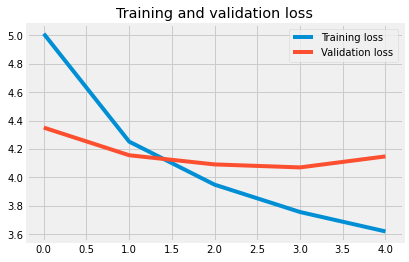

In [90]:
plot_performance(history)

In [ ]:
# testing on photo data
pred_list, score = get_bleu(test_list, features, tokenizer, max_length, model, descriptions)

1-gram BLEU: 0.4787  
2-gram BLEU: 0.2638  
3-gram BLEU: 0.1689  
4-gram BLEU: 0.0742  
3-gram and 4-gram BLEU dropped slightly but 1-gram improved. So it's classifying some of the objects better.

In [ ]:
flicker_descriptor = descriptor(features, tokenizer, processor, model)
flicker_descriptor.test_random_image(img_id)

In [ ]:
art_descriptor = descriptor(features, tokenizer, processor, model, img_dir = art_dir)
art_descriptor.test_one_image(img_id)